# Tutorial: scRNA-seq data

We show an example of scRNA-seq data produced by 10X Chromium. We are using scRNA-seq data `10k Human PBMCs, 3’ v3.1, Chromium Controller` (11,485 cells and 36,601 genes) from [10X Genomics Datasets](https://www.10xgenomics.com/resources/datasets). The test data is directly available from `Feature / cell matrix HDF5 (filtered)` in [here](https://www.10xgenomics.com/resources/datasets/10k-human-pbmcs-3-v3-1-chromium-controller-3-1-high) (registration required).

We use [scanpy](https://scanpy.readthedocs.io/en/stable/) to read/write 10X data. Import numpy and scanpy in addlition to screcode.

In [36]:
import screcode
import scanpy as sc

Read in the count matrix into an [AnnData](https://anndata.readthedocs.io/en/latest/) object. 

In [37]:
input_filename = 'data/10k_PBMC_3p_nextgem_Chromium_Controller_filtered_feature_bc_matrix.h5'
adata = sc.read_10x_h5(input_filename)
adata

C:\Users\expou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\anndata\_core\anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
C:\Users\expou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\anndata\_core\anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 11485 × 36601
    var: 'gene_ids', 'feature_types', 'genome'

## Apply RECODE
Apply RECODE to the count matrix. The **anndata** or **ndarray** data format is available. 

In [42]:
recode = screcode.RECODE()
adata = recode.fit_transform(adata)

start RECODE for scRNA-seq data


C:\Users\expou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\anndata\_core\anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


end RECODE for scRNA-seq
log: {'seq_target': 'RNA', '#significant genes': 12439, '#non-significant genes': 8969, '#silent genes': 11490, 'ell': 64, 'Elapsed time': '0h 1m 23s 146ms', 'solver': 'randomized', '#test_data': 2297}


With anndata format, outputs of RECODE are included in anndata objects:
- denoised matrix -> adata.obsm['RECODE']
- noise variance -> adata.var['noise_variance_RECODE']
- normalized variance (NVSN variance) ->  adata.var['normalized_variance_RECODE']
- clasification of genes (significant/non-significant/silent) ->  adata.var['significance_RECODE']

In [43]:
adata

AnnData object with n_obs × n_vars = 11485 × 36601
    var: 'gene_ids', 'feature_types', 'genome', 'noise_variance_RECODE', 'normalized_variance_RECODE', 'significance_RECODE'
    layers: 'RECODE', 'RECODE_ess'

### Performance check

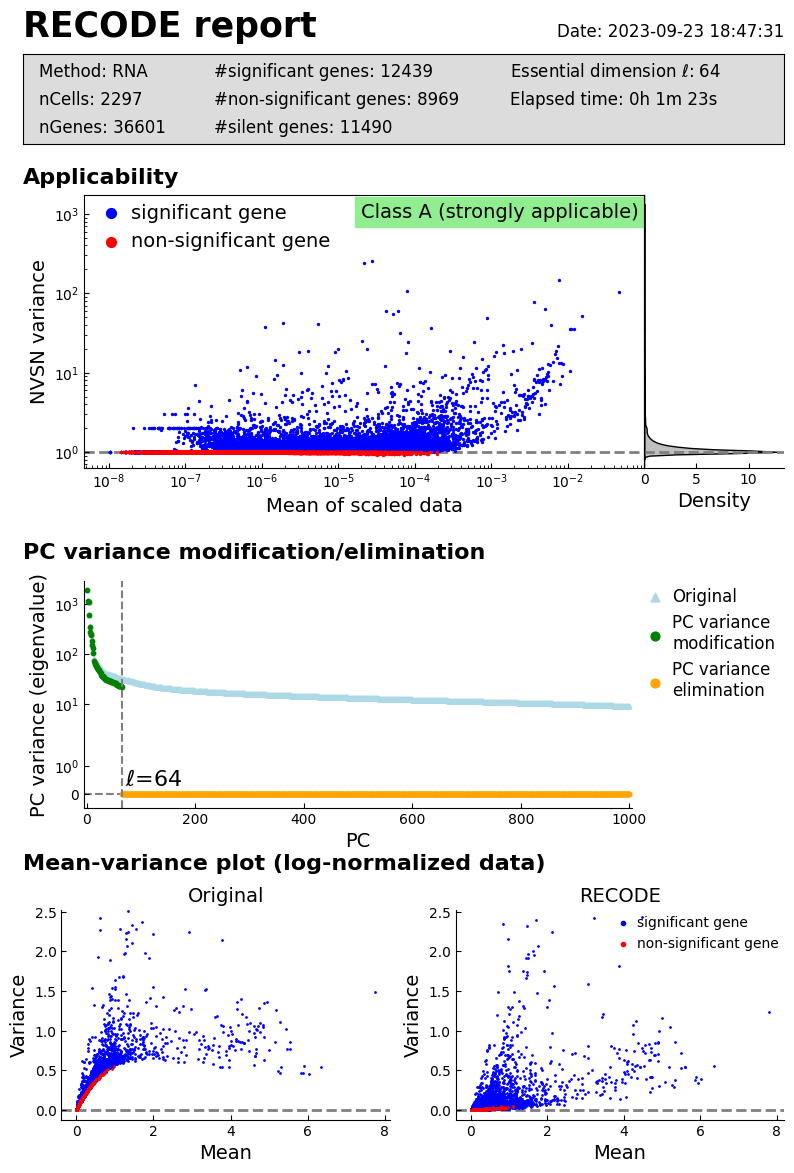

In [44]:
recode.report()

## Downstream analysis based on [scanpy](https://scanpy.readthedocs.io/en/stable/index.html)

In [45]:
import numpy as np
adata.layers["Raw"] = adata.X.toarray()

### log normalization

In [46]:
adata.X = adata.layers["RECODE"]
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

### PCA

In [47]:
sc.tl.pca(adata, svd_solver='arpack')

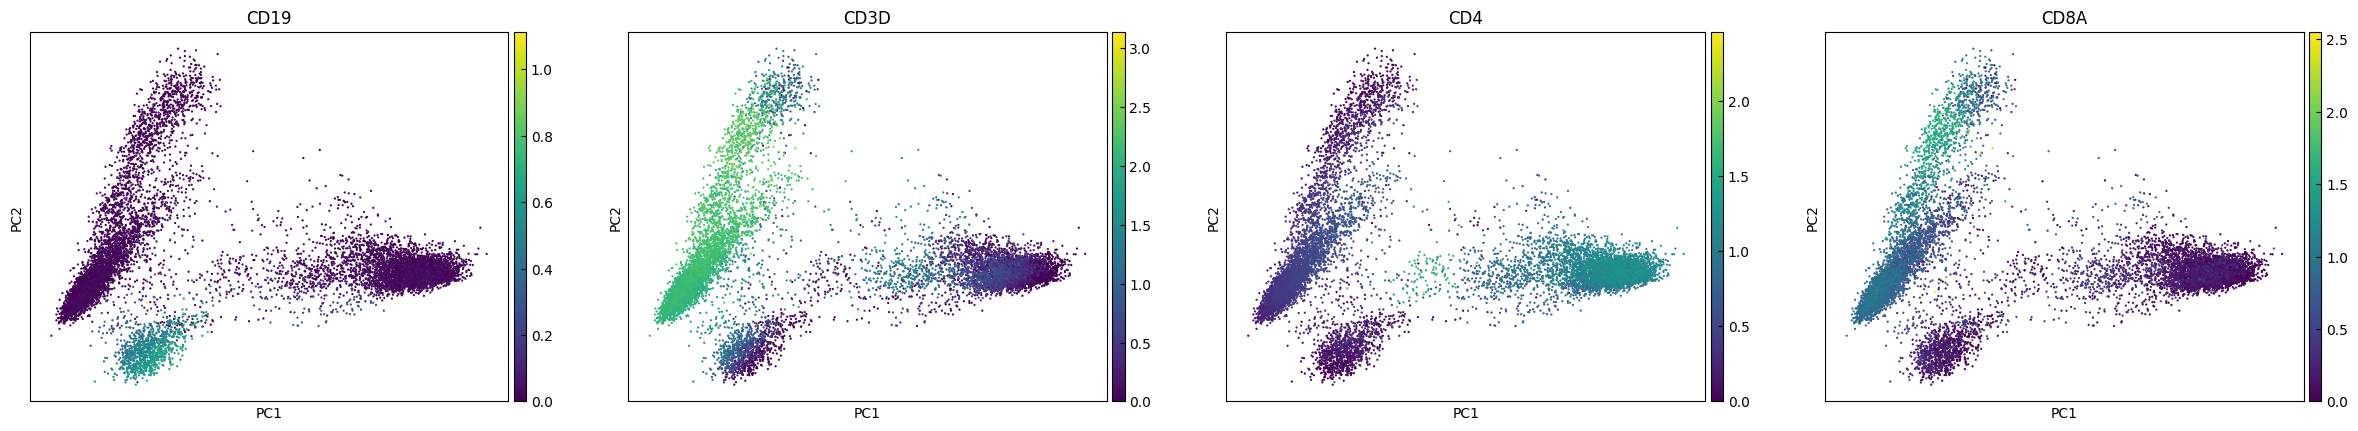

In [48]:
plot_genes = ['CD19','CD3D','CD4','CD8A']
sc.pl.pca(adata, color=plot_genes)

### UMAP

Note that we do not use the PCA dimentionaly reduction as a preprocessing of UMAP (`n_pca=0`). 

In [49]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=0)
sc.tl.umap(adata)

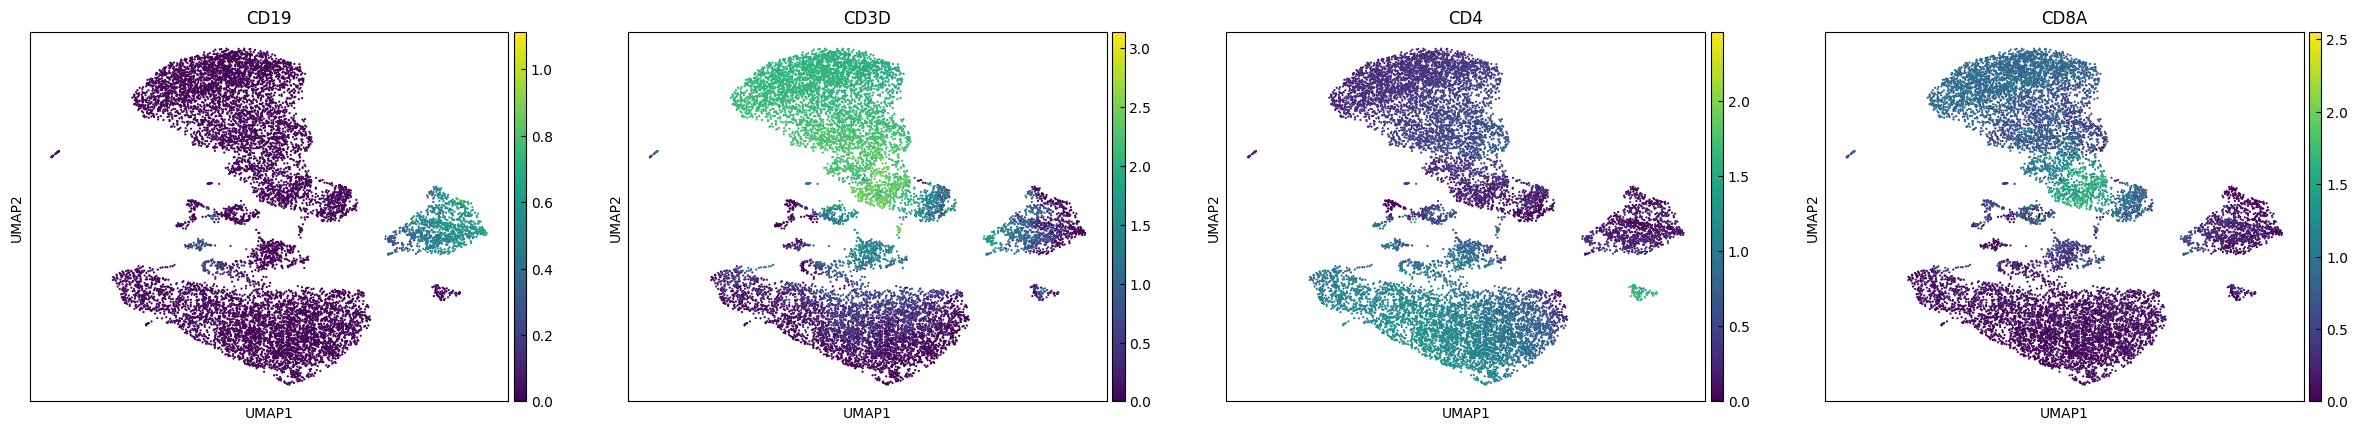

In [50]:
sc.pl.umap(adata, color=plot_genes)

## Clustering

C:\Users\expou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


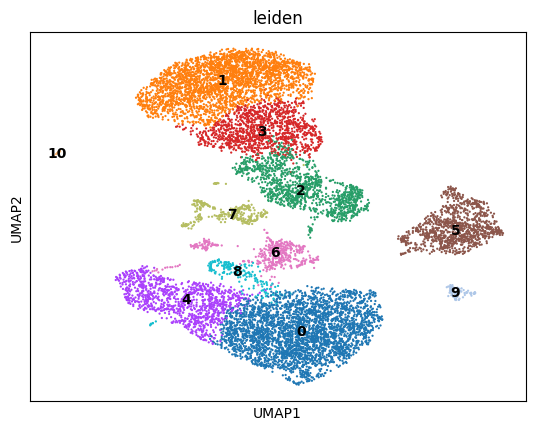

In [94]:
sc.tl.leiden(adata,resolution=0.3)
sc.pl.umap(adata, color=['leiden'],legend_loc='on data')

## Find marker genes

In [81]:
threshold_mean = 0.5
adata_marker = adata[:,np.mean(adata.X,axis=0)>threshold_mean]
sc.tl.rank_genes_groups(adata_marker, 'leiden', method='t-test')
# sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

C:\Users\expou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scanpy\tools\_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


In [82]:
marker_genes = list(adata_marker.uns['rank_genes_groups']['names'][0]) # The top marker genes for each cluster

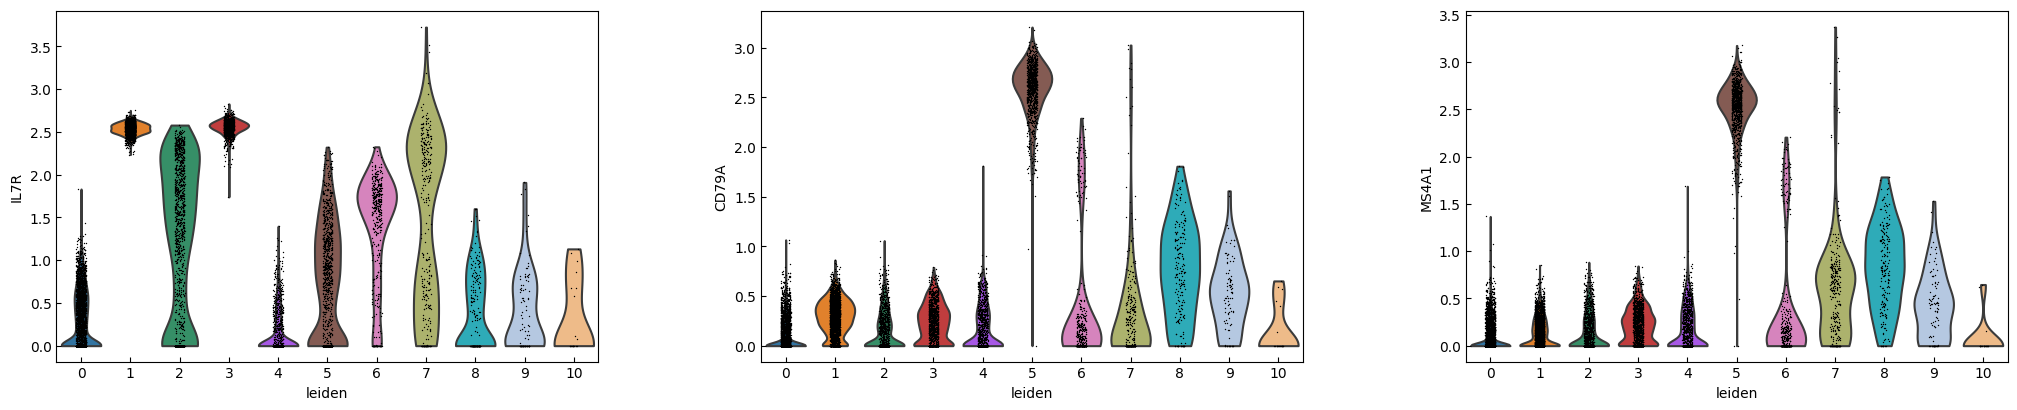

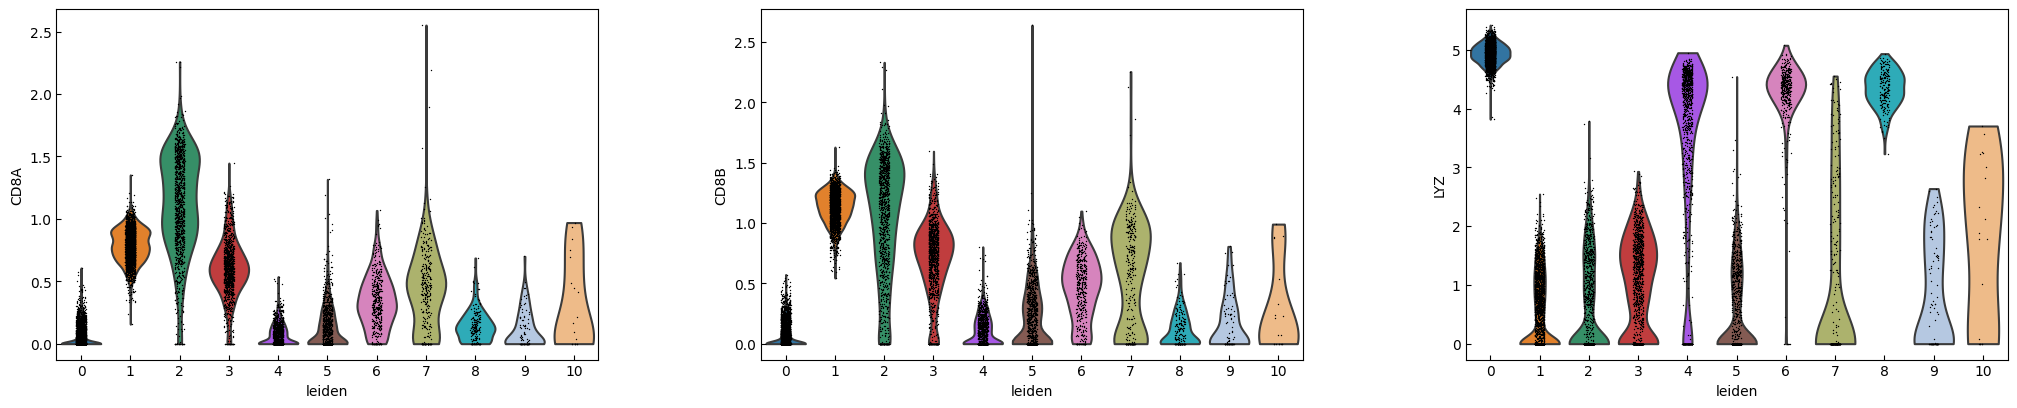

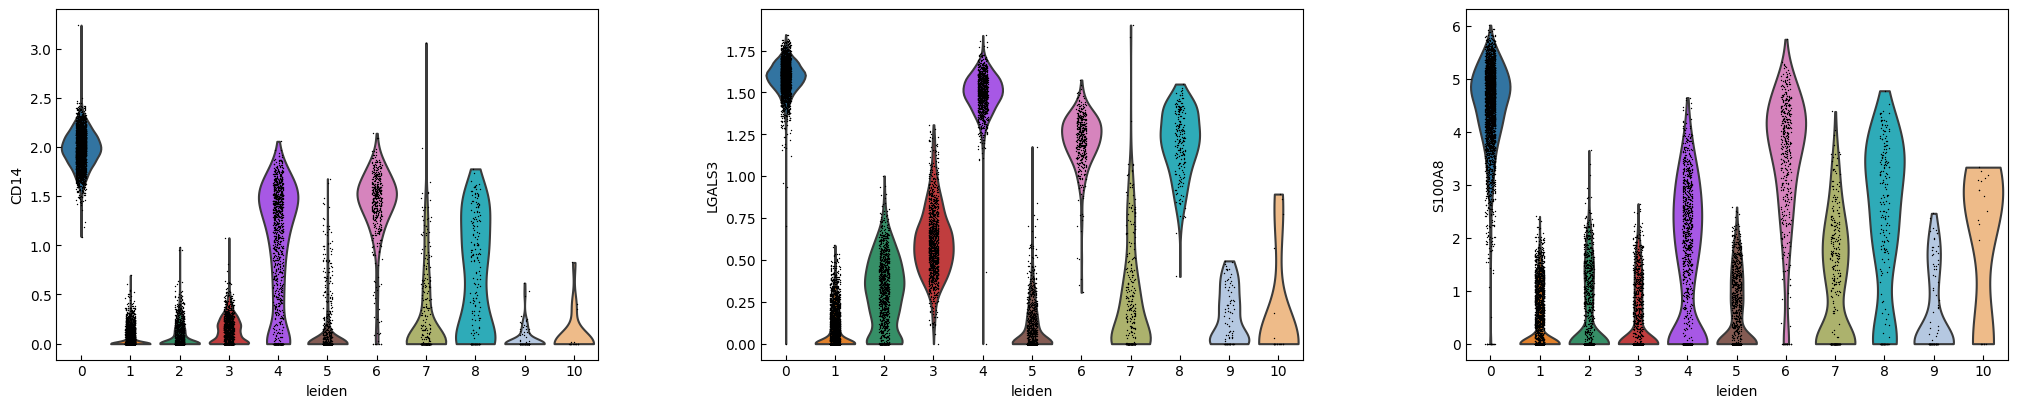

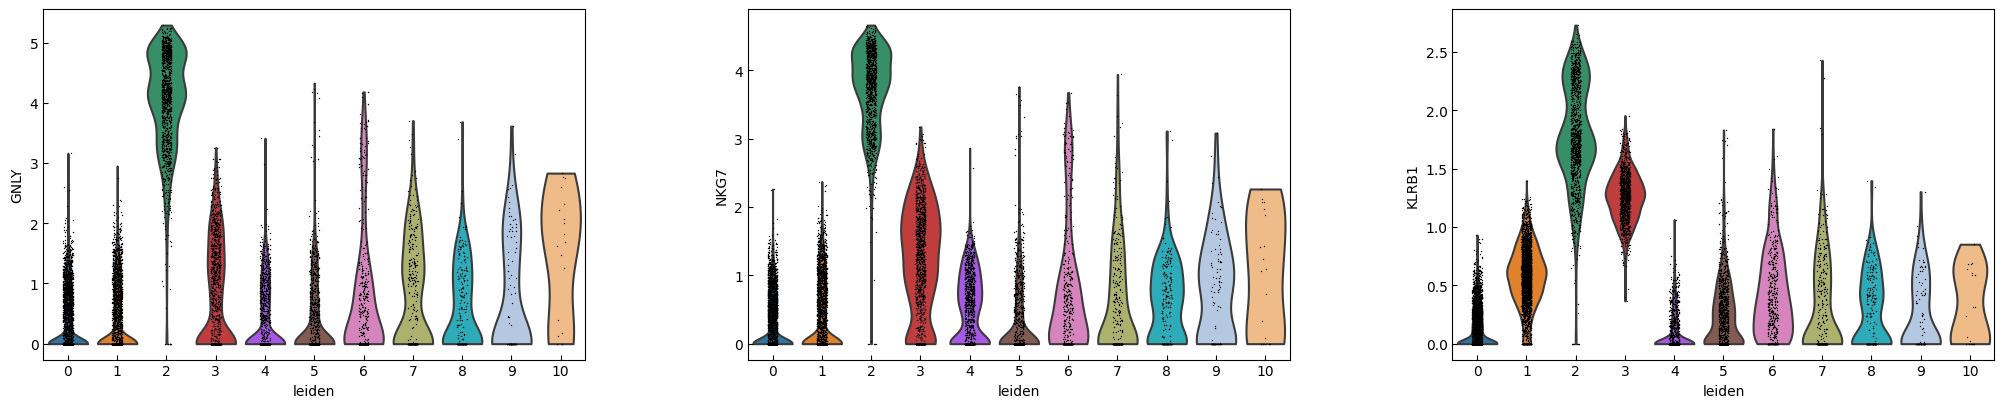

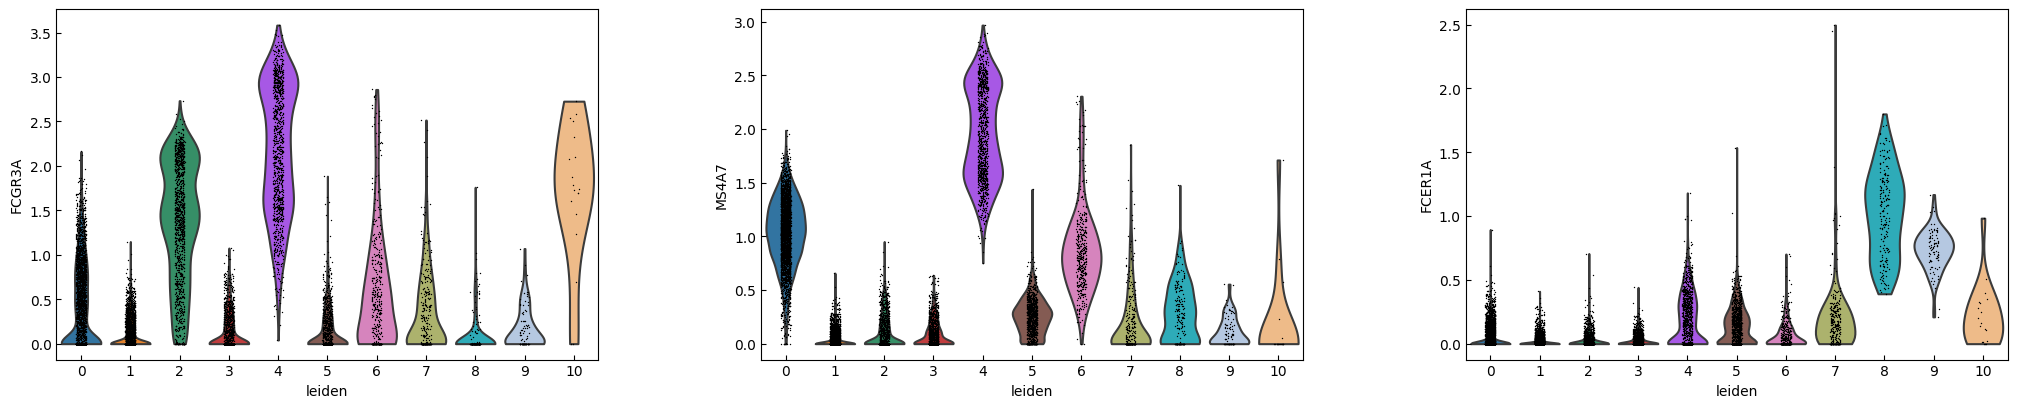

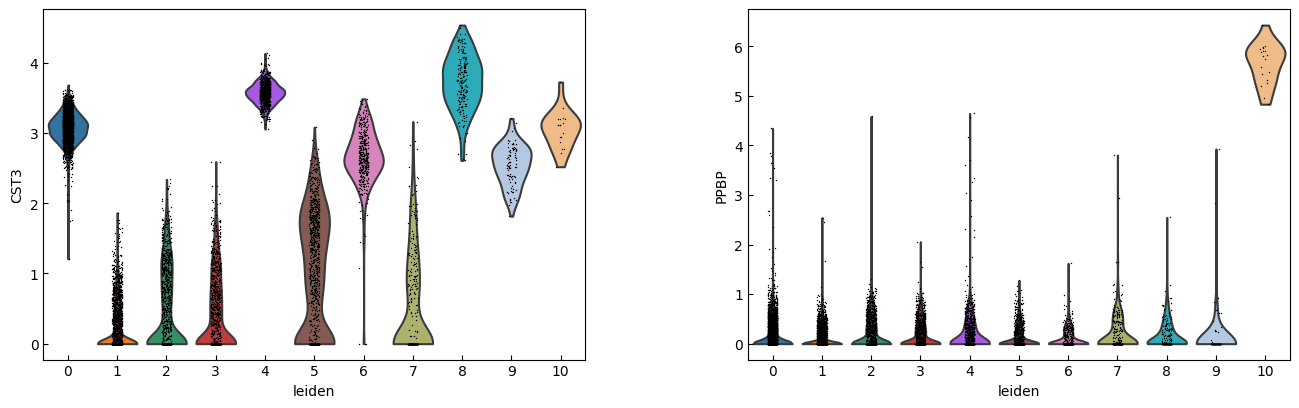

In [95]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']
adata.var_names_make_unique()
n_cols = 3
for i in range(0, len(marker_genes),n_cols):
    sc.pl.violin(adata, marker_genes[i:i+n_cols], groupby='leiden')

C:\Users\expou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scanpy\plotting\_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


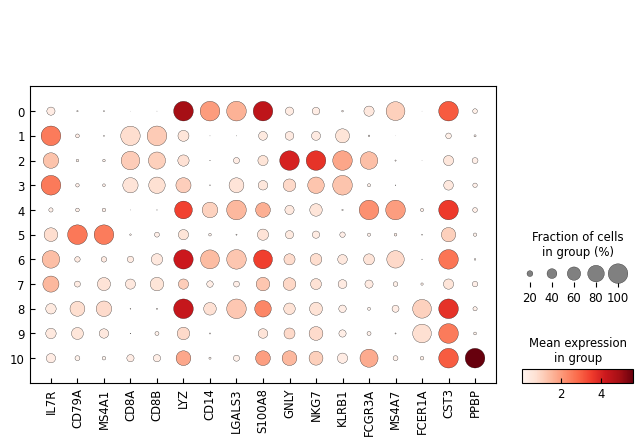

In [97]:
sc.pl.dotplot(adata, marker_genes, groupby='leiden',expression_cutoff=0.5)

C:\Users\expou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


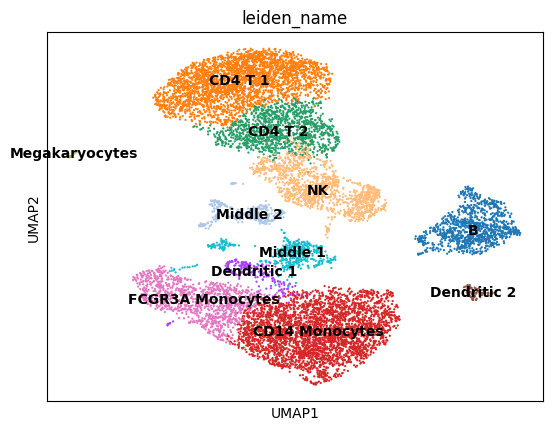

In [111]:
new_cluster_names = [
    'CD14 Monocytes','CD4 T 1', 'NK', 'CD4 T 2','FCGR3A Monocytes',
    'B', 'Middle 1', 'Middle 2', 'Dendritic 1', 'Dendritic 2', 'Megakaryocytes']
adata.obs["leiden_name"] = [new_cluster_names[int(i)] for i in adata.obs["leiden"].values]
sc.pl.umap(adata, color='leiden_name', legend_loc='on data')

### Gene expression distributions

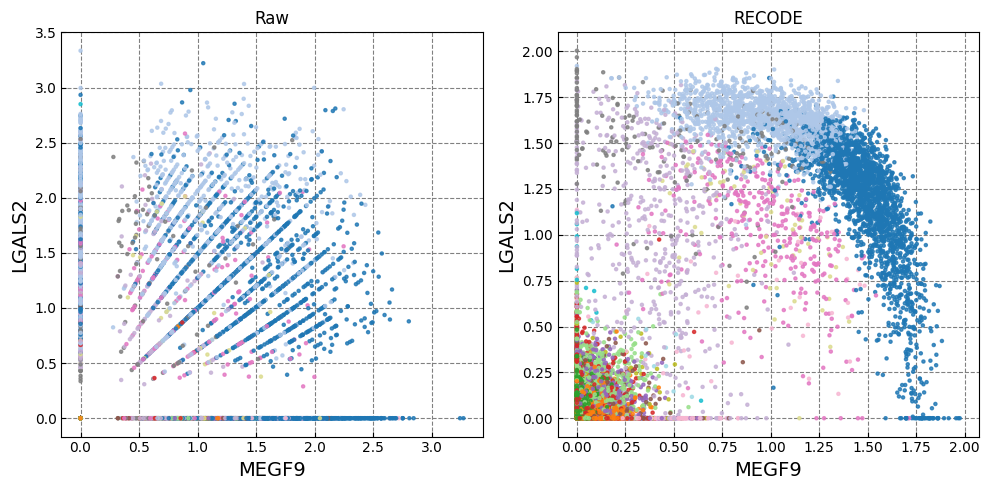

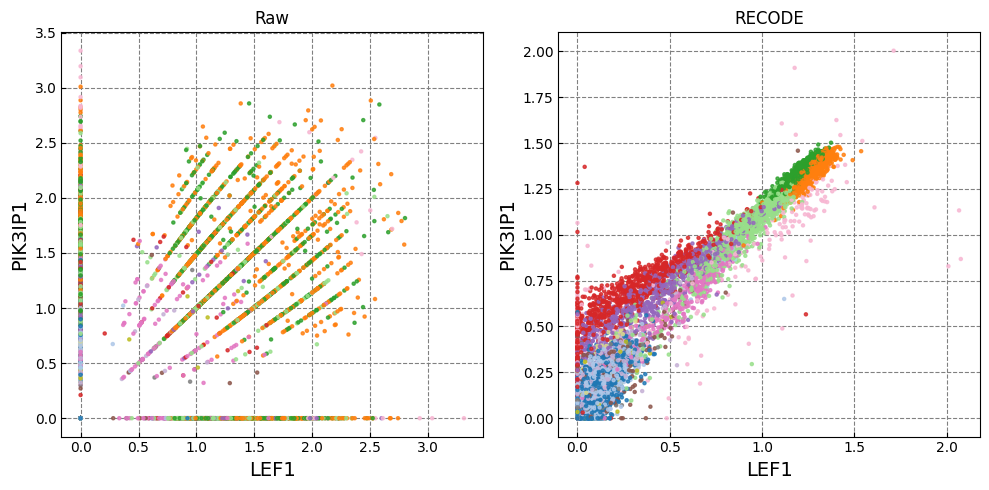

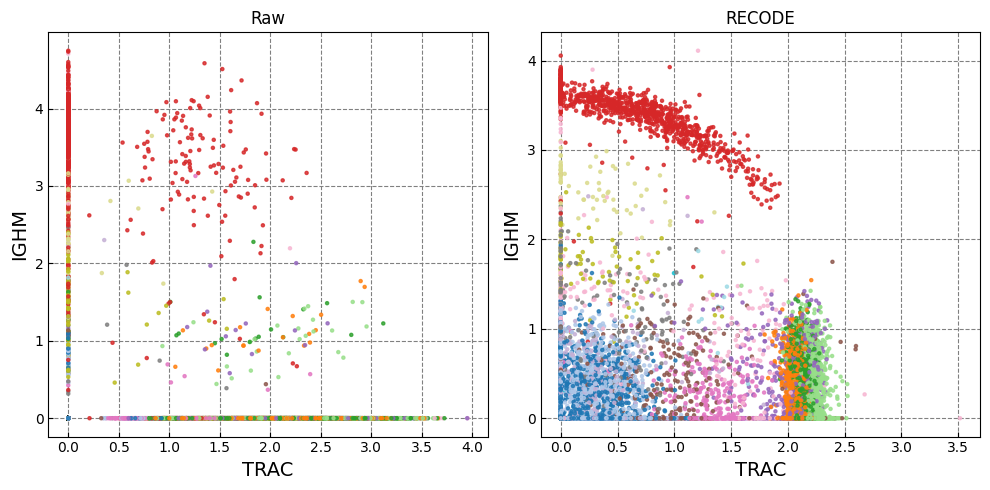

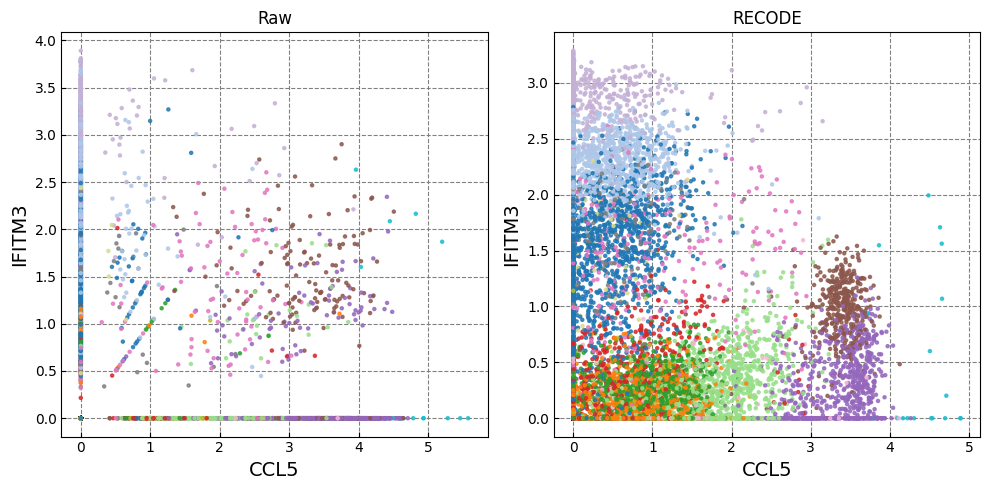

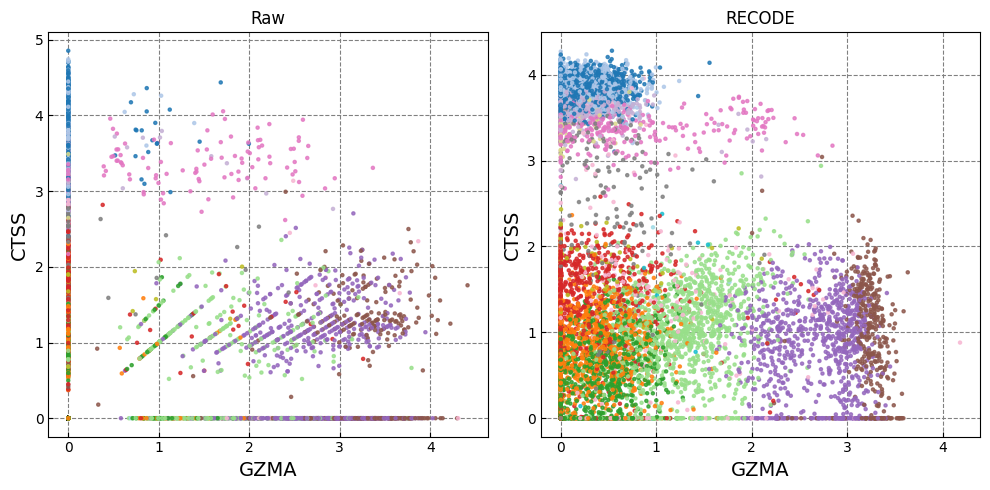

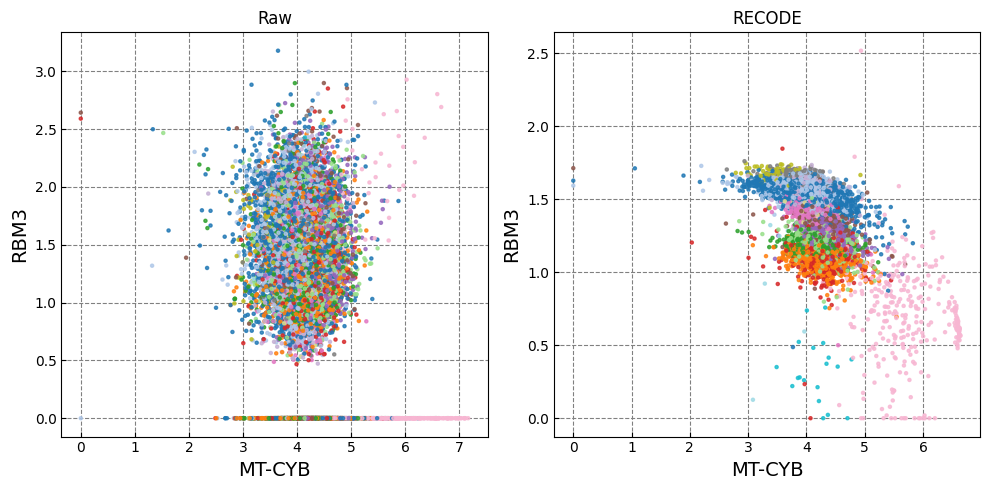

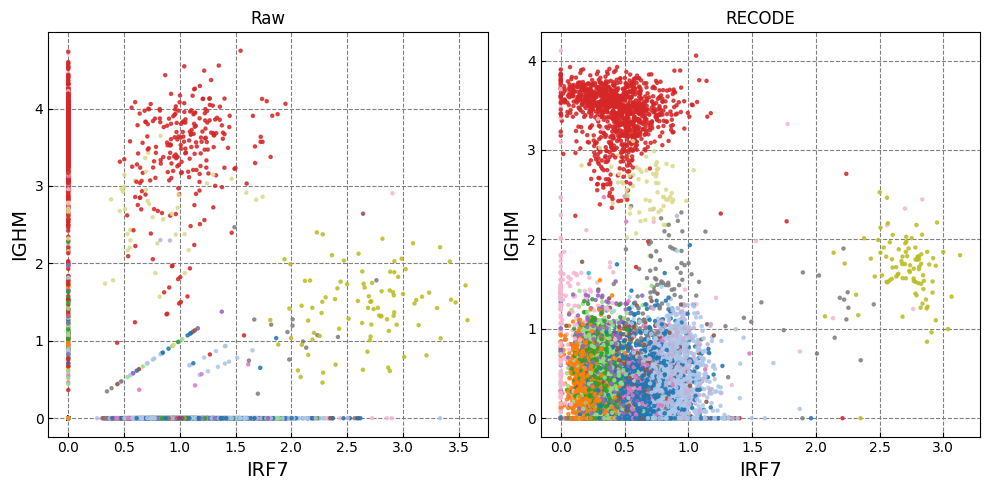

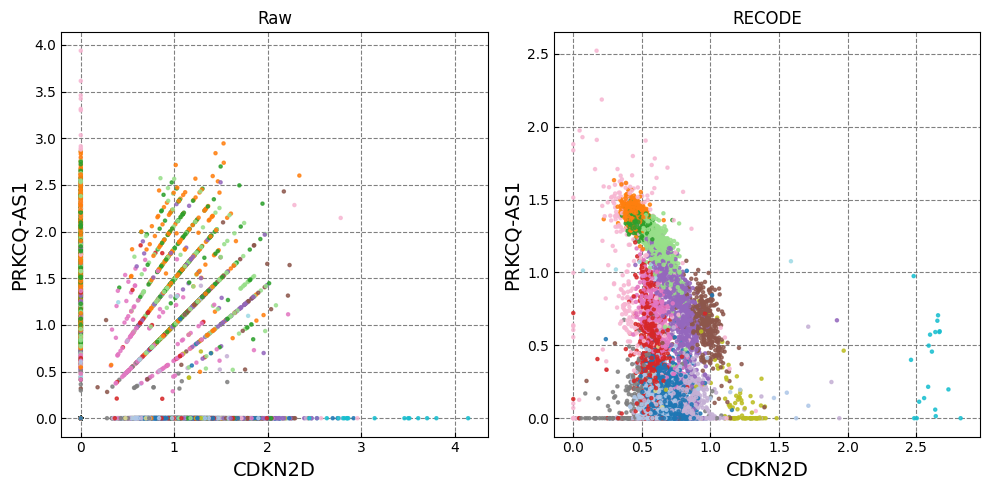

In [87]:
import matplotlib.pyplot as plt

size_factor = 1e4
alpha = 0.8
ps = 5
fontsize_label = 14
plot_data = [np.log(size_factor*adata.layers['Raw'].T/np.sum(adata.layers['Raw'],axis=1)+1).T,adata.X]
names = ['Raw','RECODE']
color = np.array(adata.obs['leiden'].values,dtype=int)

n_plot = len(names)
n_ax =  n_plot * n_col_genes
for k in range(0, len(marker_genes),2):
    if k+1 >= len(marker_genes): break
    fig,ax = plt.subplots(1,n_ax,figsize=(5*n_ax,5),tight_layout=True)
    for i in range(n_plot):
        i_ax = n_plot*j+i
        g1_,g2_ = marker_genes[k],marker_genes[k+1]
        ax[i_ax].scatter(plot_data[i][:,adata.var.index==g1_], plot_data[i][:,adata.var.index==g2_], c=color, alpha=alpha,zorder=10,s=ps,cmap='tab20')
        ax[i_ax].set_xlabel(g1_,fontsize=fontsize_label)
        ax[i_ax].set_ylabel(g2_,fontsize=fontsize_label)
        ax[i_ax].set_title(names[i])
        ax[i_ax].grid(ls='--',color='gray',zorder=0)